In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1)
    

for data in test_r1b2_loader:
    U_t2, Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = True,
                                  decay = 40,
                                  thresh = 0)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2)


In [3]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-4)

In [4]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=101, n_iter=30, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "kl")

epoch:  0 RNA loss: 5.73001, RNA recon loss: 0.00000, RNA dist loss: 5.73001 ATAC loss: 5.44377, ATAC recon loss: 0.00000, ATAC dist loss: 5.44377 Discriminator loss: 0.68939
epoch:  10 RNA loss: 2.84694, RNA recon loss: 0.00000, RNA dist loss: 2.84694 ATAC loss: 2.49691, ATAC recon loss: 0.00000, ATAC dist loss: 2.49691 Discriminator loss: 0.69442
epoch:  20 RNA loss: 2.52331, RNA recon loss: 0.00000, RNA dist loss: 2.52331 ATAC loss: 1.86978, ATAC recon loss: 0.00000, ATAC dist loss: 1.86978 Discriminator loss: 0.69134
epoch:  30 RNA loss: 2.27229, RNA recon loss: 0.00000, RNA dist loss: 2.27229 ATAC loss: 1.47033, ATAC recon loss: 0.00000, ATAC dist loss: 1.47033 Discriminator loss: 0.68832
epoch:  40 RNA loss: 0.97279, RNA recon loss: 0.00000, RNA dist loss: 0.97279 ATAC loss: 0.94637, ATAC recon loss: 0.00000, ATAC dist loss: 0.94637 Discriminator loss: 0.68529
epoch:  50 RNA loss: 0.60484, RNA recon loss: 0.00000, RNA dist loss: 0.60484 ATAC loss: 0.52888, ATAC recon loss: 0.0000

In [5]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config': symsim_CONFIG
# }, './saved_model/symsim_phate.pt')

In [6]:
# state = torch.load('./saved_model/symsim_phate.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

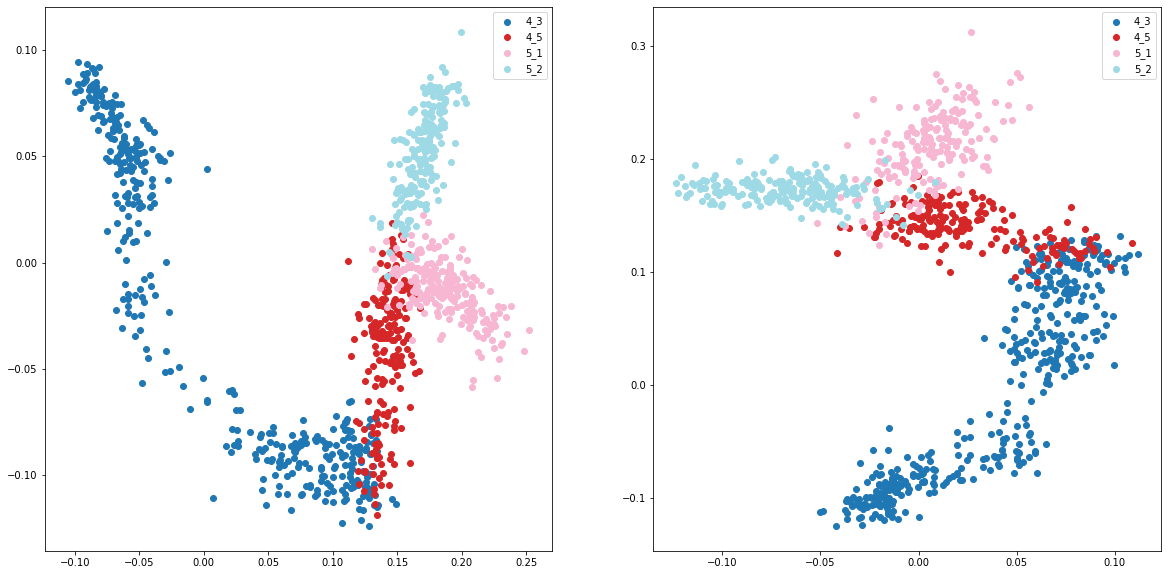

In [5]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels["pop"], anno2 = symsim_r1b2.cell_labels["pop"], mode = "separate",save = None)

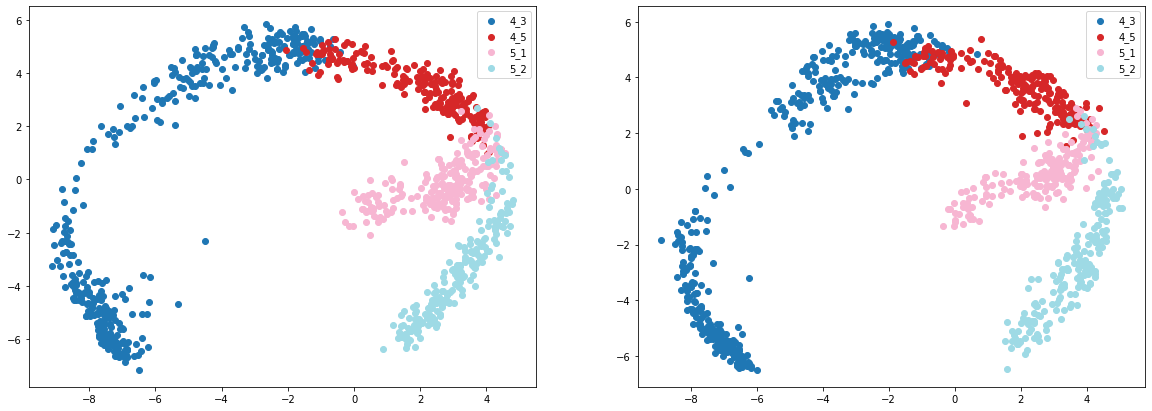

In [27]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)

fig.savefig("./result/Symsim/phate_backbones_separate.pdf")

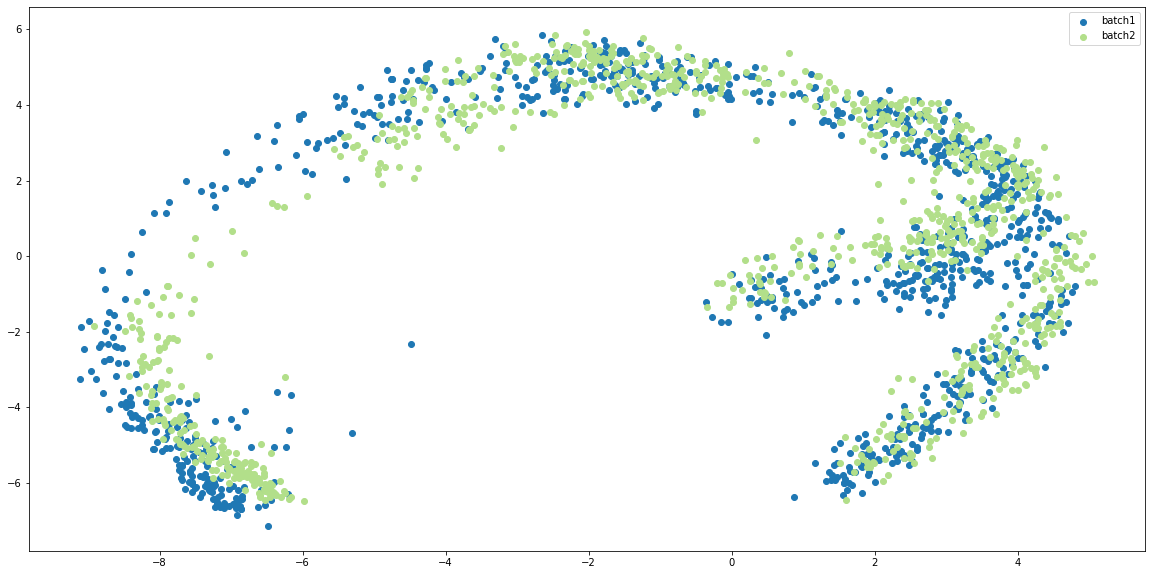

In [28]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()

fig.savefig("./result/Symsim/phate_batches_phate.pdf")